In [5]:
from google.colab import drive
drive.mount("/content/gdrive/")
!ls "/content/gdrive/My Drive/Sigmoid"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
kmnist_classmap.csv  kmnist-test-imgs.npy   kmnist-train-labels.npy
KMNIST.ipynb	     kmnist-train-imgs.npy


In [29]:
%pylab inline
!pip install pycm livelossplot

from livelossplot import PlotLosses
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

Populating the interactive namespace from numpy and matplotlib
Cuda installed! Running on GPU!


In [0]:
path="/content/gdrive/My Drive/Sigmoid/"
train_data = np.load(path+"kmnist-train-imgs.npy")
test_data = np.load(path+"kmnist-test-imgs.npy")
train_labels = np.load(path+"kmnist-train-labels.npy")
classmap = pd.read_csv(path+"kmnist_classmap.csv")

In [9]:
classmap.head()

,index,codepoint,char
0,0,U+304A,お
1,1,U+304D,き
2,2,U+3059,す
3,3,U+3064,つ
4,4,U+306A,な


In [20]:
# Basic EDA

print("Train Data:", train_data.shape)
print("Test Data:", test_data.shape)
print("Train Labels:", train_labels.shape)

Train Data: (60000, 28, 28)
Test Data: (10000, 28, 28)
Train Labels: (60000,)


In [0]:
# Tensor of training data
X = torch.from_numpy(train_data).float()
# Tensor of training labels
y = torch.from_numpy(train_labels).long()
#  Tensor of test data
X_test = torch.from_numpy(test_data).float()

In [0]:
class CustomTensorDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.view(1, 28, 28).float()/255.
        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [0]:
class SupervisedLearning:
    def __init__(self, X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                 normalise=True,
                 device="cpu", 
                 confusion_matrix=True, 
                 train_transform=None,
                 val_transform=None, 
                 seed=42, n_epochs=30, 
                 save_best_weights = True):
      
      self.device = device
      
      self.X = X
      self.y = y
      
      self.model = model.to(self.device)
      self.optimiser = optimiser
      self.loss_function = loss_function
      
      self.X_train = None
      self.X_val = None
      
      self.y_train = None
      self.y_val = None
      
      self.train_transform = train_transform
      self.val_transform = val_transform
      
      assert(batch_size > 0 and batch_size < int(0.1 * X.size()[0]))
      self.batch_size = batch_size
      assert(test_batch_size > 0 and test_batch_size < int(0.1 * X.size()[0]))
      self.test_batch_size = test_batch_size
      self.n_epochs = n_epochs
      self.seed = seed

      self.trained_full=False
      
      
    def split_data(self):
      sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
      sss.get_n_splits(self.X, self.y)

      for train_index, val_index in sss.split(self.X, self.y):
        self.X_train, self.X_val = self.X[train_index], self.X[val_index]
        self.y_train, self.y_val = self.y[train_index], self.y[val_index]
        
      return None
      
      
    def train(self, train_data_loader):
      self.model.train()                     # set model to train mode
      
      train_loss, train_accuracy = 0., 0.
      
      for Xtr, ytr in train_data_loader:# X and y are data inside a batch specified
                                        # at train_data_loader
        Xtr = Xtr.to(self.device)
        ytr = ytr.to(self.device)
        
        optimiser.zero_grad()           # reset gradients
        zn = model(Xtr)                 # perform forward pass
        
        loss = loss_function(zn, ytr)   # compute loss value over batch
        loss.backward()                 # perform backward pass
        train_loss += (loss * Xtr.size()[0]).detach().cpu().numpy()
      
        y_pred = F.log_softmax(zn, dim=1).max(1)[1]
        train_accuracy += accuracy_score(ytr.cpu().numpy(), y_pred.detach().cpu().numpy())*Xtr.size()[0]
        
        optimiser.step()               # optimisation step
        
      return train_loss/len(train_data_loader.dataset), train_accuracy/len(train_data_loader.dataset)
    
    
    
    def validate(self, val_data_loader):
      self.model.eval()                     # set model to evaluation mode
      
      validation_loss, validation_accuracy = 0., 0.
      
      for Xv, yv in val_data_loader:
        with torch.no_grad():
          
          Xv, yv = Xv.to(self.device), yv.to(self.device)
          
          zn = model(Xv)
          loss = loss_function(zn, yv)
          validation_loss += (loss * Xv.size(0)).detach().cpu().numpy()
          
          y_pred = F.log_softmax(zn, dim=1).max(1)[1]
          validation_accuracy += accuracy_score(yv.cpu().numpy(), y_pred.detach().cpu().numpy())*Xv.size(0)

            
      return validation_loss/len(val_data_loader.dataset), validation_accuracy/len(val_data_loader.dataset)
    
    
    def train_model(self, train_full=False, plot_loss=True):
      # set seed
      set_seed(int(self.seed))
      
      
      if train_full: # train with full data (train + validation)
        # create dataloaders
        train_dataset = CustomTensorDataset(self.X, self.y, transform=self.train_transform)
        train_data_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        # train and validate
        if plot_loss: liveloss = PlotLosses()
        for epoch in range(self.n_epochs):
            logs = {}
            train_loss, train_accuracy = self.train(train_data_loader)

            if plot_loss:
              logs['' + 'log loss'] = train_loss.item()
              logs['' + 'accuracy'] = train_accuracy.item()
              logs['val_' + 'log loss'] = train_loss.item()
              logs['val_' + 'accuracy'] = train_accuracy.item()
              liveloss.update(logs)
              liveloss.draw()
              
        self.trained_full=True

      else:
        # split data
        self.split_data()
        
        # create dataloaders
        train_dataset = CustomTensorDataset(self.X_train, self.y_train, transform=self.train_transform)
        train_data_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_dataset = CustomTensorDataset(self.X_val, self.y_val, transform=self.val_transform)
        val_data_loader = DataLoader(val_dataset, batch_size=self.test_batch_size, shuffle=True)
        
        # train and validate
        if plot_loss: liveloss = PlotLosses()
        for epoch in range(self.n_epochs):
            logs = {}
            train_loss, train_accuracy = self.train(train_data_loader)
            val_loss, val_accuracy = self.validate(val_data_loader)

            if plot_loss:
              logs['' + 'log loss'] = train_loss.item()
              logs['' + 'accuracy'] = train_accuracy.item()
              logs['val_' + 'log loss'] = val_loss.item()
              logs['val_' + 'accuracy'] = val_accuracy.item() # liveloss wants it plotted
              liveloss.update(logs)
              liveloss.draw() 

        self.trained_full=False
              
      return None
            
            
    def evaluate_batch(self, X_test, y_test, confusion_matrix=True, test_transform=None):
      """
      This method performs the same as validate but also returns all predictions on a given dataset
      for a trained model.
      """
      self.model.eval()
      
      test_dataset = CustomTensorDataset(X_test, y_test, transform=test_transform)
      test_data_loader = DataLoader(test_dataset, batch_size=self.test_batch_size, shuffle=True)
      
      ys, y_preds = [], []
      
      for X, y in test_data_loader:
          with torch.no_grad():
              X, y = X.to(self.device), y.to(self.device)
              a2 = self.model(X)
              y_pred = F.log_softmax(a2, dim=1).max(1)[1]
              ys.append(y.cpu().numpy())
              y_preds.append(y_pred.cpu().numpy())
            
      y_preds, ys =  np.concatenate(y_preds, 0),  np.concatenate(ys, 0)
      
      test_loss, test_accuracy = self.validate(test_data_loader)
      
      if confusion_matrix:
        cm = ConfusionMatrix(actual_vector=ys, predict_vector=y_preds)
        print(cm)
        
        
      return y_preds, ys, test_loss, test_accuracy

In [0]:
# Hyperparameters
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

In [0]:
# Model and Optimiser selection

class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    # The implementation of the LeNet5 architecture
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()
    
  def forward(self, x):
    # Applying the ReLU activation function throughout the net
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)
  
model = LeNet5()
optimiser = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
loss_function = nn.CrossEntropyLoss()

In [0]:
learning = SupervisedLearning(X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                              n_epochs=n_epochs, device=device)

In [44]:
print(X.shape, y.shape)

torch.Size([60000, 28, 28]) torch.Size([60000])


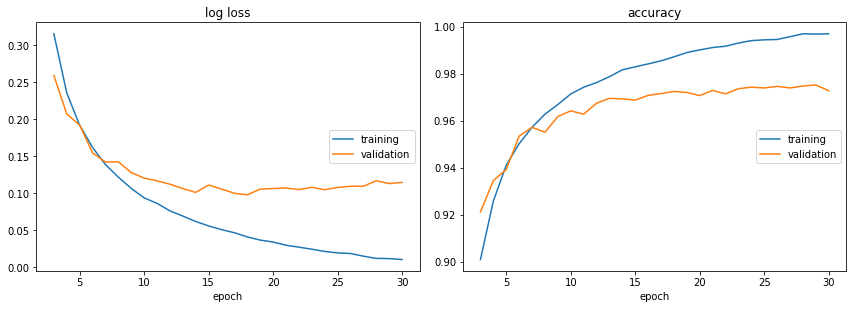

log loss:
training   (min:    0.010, max:    1.539, cur:    0.010)
validation (min:    0.098, max:    0.616, cur:    0.115)

accuracy:
training   (min:    0.499, max:    0.997, cur:    0.997)
validation (min:    0.805, max:    0.975, cur:    0.973)


In [45]:
learning.train_model()

In [0]:
print()

In [0]:
# Saving the model to my google drive
model_save_name = 'LeNET' + '' + '.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)